0. Libraries

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from hmmlearn import hmm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib
import os

1. Download Data

In [2]:
# Download historical data
ticker = "GC=F"
data = yf.download(ticker, start="2000-01-01", end="2025-03-01")
data = data[['Open', 'High', 'Low', 'Close']]
lookback = 21

# Create features
data['Returns'] = data['Close'].pct_change() * 100  # Percentage returns
data['Volatility'] = data['Returns'].rolling(lookback, min_periods=1).std()  # Historical volatility
# Calculate True Range (TR)
prev_close = data['Close'].shift(1)
high_low = data['High'] - data['Low']
high_prev_close = (data['High'] - prev_close).abs()
low_prev_close = (data['Low'] - prev_close).abs()
data['TR'] = pd.concat([high_low, high_prev_close, low_prev_close], axis=1).max(axis=1)
data = data.iloc[lookback:]  # Keeps all rows from lookback period onward
data.dropna(inplace=True)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


2. Add Features

In [3]:
"""Scale features using walk-forward method"""
# Initialize scaler with first observation
scaler = StandardScaler()
scaled_features = np.zeros((len(data), 2))

# Walk-forward scaling
for i in range(len(data)):
    if i < 21:  # Warm-up period for volatility
        scaled_features[i] = [0, 0]
        continue
        
    # Use only data up to current point for scaling
    current_data = data.iloc[:i+1]
    scaler.fit(current_data[['Returns', 'Volatility']])
    # Reshape the current observation to 2D array
    current_observation = data.iloc[i][['Returns', 'Volatility']].values.reshape(1, -1)
    scaled_features[i] = scaler.transform(current_observation)

features = pd.DataFrame(scaled_features, columns=['Returns', 'Volatility'], index=data.index)

3. Train-Test Split

In [9]:
# Split into train/test (2010-2020 train, 2020-2025 test)
train_mask = features.index < '2020-01-01'
# train_mask = features.index > '2024-01-01'
test_mask = features.index >= '2020-01-01'

4. Train Hidden Markov Model

In [10]:
"""Train HMM with multiple initializations"""
best_model = None
best_score = -np.inf
n_states = 3

# Multiple initializations to avoid local maxima
for _ in range(10):
    model = hmm.GaussianHMM(
        n_components=n_states,
        covariance_type="full",
        n_iter=1000,
        implementation="log",
        random_state=np.random.randint(0, 1000)
    )
    model.fit(features[train_mask])
    score = model.score(features[train_mask])
    if score > best_score:
        best_score = score
        best_model = model

5. Predict Regimes

In [11]:
# Predict on entire dataset (test predictions are out-of-sample)
hidden_states = model.predict(features)
data['Regime'] = hidden_states

6. Plot Data

C:\Users\najdu\AppData\Local\Temp\ipykernel_13780\1339529631.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', model.n_components)


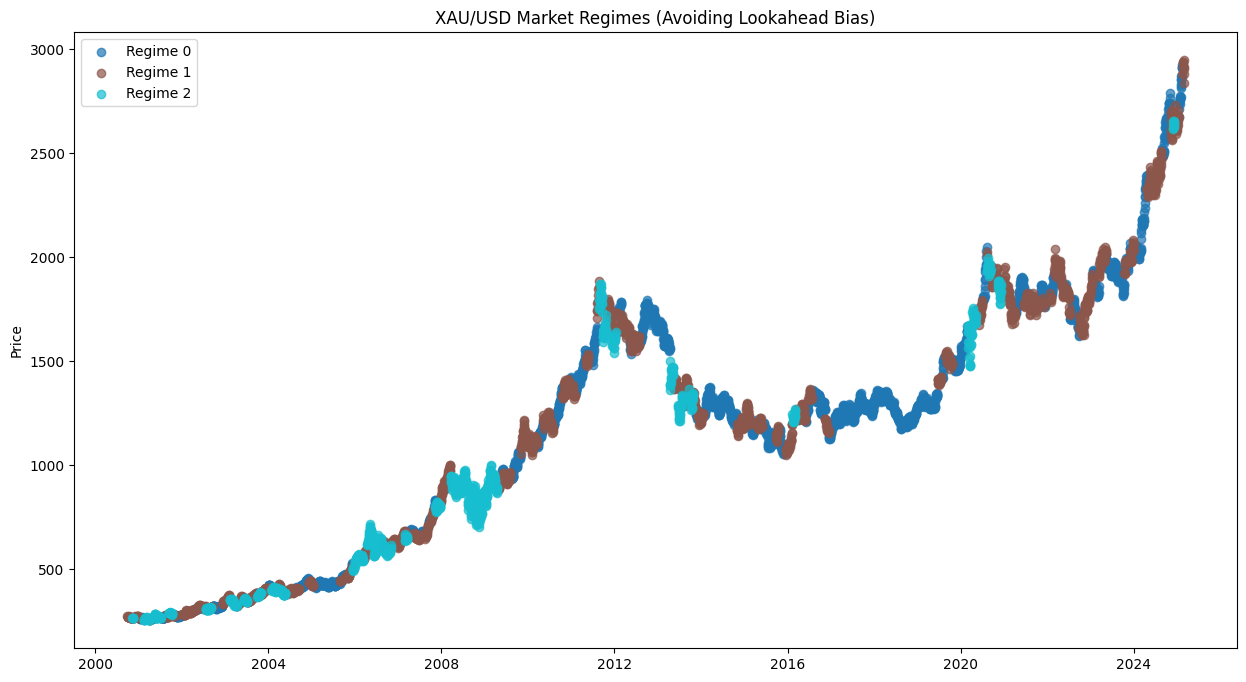

Regime Characteristics (Train Period 2010-2024):

Regime 0:
Average Return: 0.0499%
Average Volatility: 0.7234%
Duration: 45.3%

Regime 1:
Average Return: 0.0753%
Average Volatility: 1.0533%
Duration: 35.2%

Regime 2:
Average Return: -0.0393%
Average Volatility: 1.6472%
Duration: 19.5%

Test Set Results (2024-2025):

Regime 0 occurred 594 times
Test Period Returns: 0.1128%

Regime 1 occurred 604 times
Test Period Returns: 0.0126%

Regime 2 occurred 100 times
Test Period Returns: -0.0542%


In [12]:
# Plot results
plt.figure(figsize=(15, 8))
# Dynamically generate colors based on number of regimes
colors = plt.cm.get_cmap('tab10', model.n_components)

for i in range(model.n_components):
    mask = data['Regime'] == i
    plt.scatter(data.index[mask], data['Close'][mask], 
                c=[colors(i)], label=f'Regime {i}', alpha=0.7)

plt.title('XAU/USD Market Regimes (Avoiding Lookahead Bias)')
plt.ylabel('Price')
plt.legend()
plt.show()

# Print regime statistics (train set only for parameters)
print("Regime Characteristics (Train Period 2010-2024):")
train_data = data[train_mask]
for i in range(model.n_components):
    regime_data = train_data[train_data['Regime'] == i]
    print(f"\nRegime {i}:")
    print(f"Average Return: {regime_data['Returns'].mean():.4f}%")
    print(f"Average Volatility: {regime_data['Volatility'].mean():.4f}%")
    print(f"Duration: {len(regime_data)/len(train_data):.1%}")

# Test set evaluation
print("\nTest Set Results (2024-2025):")
test_data = data[test_mask]
for i in range(model.n_components):
    regime_data = test_data[test_data['Regime'] == i]
    print(f"\nRegime {i} occurred {len(regime_data)} times")
    print(f"Test Period Returns: {regime_data['Returns'].mean():.4f}%")

7. Save Model

In [13]:
def save_model(model, filename="hmm_xauusd_model.pkl"):
    """Save the trained HMM model to a file"""
    joblib.dump(model, filename)
    print(f"Model saved to {filename}")

def load_model(filename="hmm_xauusd_model.pkl"):
    """Load a trained HMM model from a file"""
    if not os.path.exists(filename):
        raise FileNotFoundError(f"Model file {filename} not found")
    model = joblib.load(filename)
    print(f"Model loaded from {filename}")
    return model

# Save the trained model
save_model(best_model, "hmm_xauusd_model.pkl")

# Load the model (for demonstration)
loaded_model = load_model("hmm_xauusd_model.pkl")

Model saved to hmm_xauusd_model.pkl
Model loaded from hmm_xauusd_model.pkl
